# Importing libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

/Users/sabha6947/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Loading data

In [2]:
# Load data from CSV file
data = pd.read_csv('Data/consolidated_2.csv')
    
# Assuming the CSV has columns: student_id, timestamp, feature1, feature2, feature3, feature4, feature5, label
features = ['os_ukc_aft', 'os_heading', 'os_mainbeckerrudder_angle', 'sune_DOA', 'aarts_DOA']
X = data[features].values
y = data['label'].values

# Splitting and pre-processing data

In [3]:
# SPLIT IN TRAIN AND TEST DATA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 7)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, shuffle= False)
# # Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Model intialization, fitting and evaluation
Model 1: XGboost

In [4]:
from xgboost import XGBClassifier
model_1 = XGBClassifier()
eval_set = [(X_train, y_train), (X_test, y_test)]

# Fit the model
model_1.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set= eval_set, verbose = False)

# Evaluation results
results = model_1.evals_result()

/Users/sabha6947/Library/Python/3.9/lib/python/site-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


# Plotting metrics

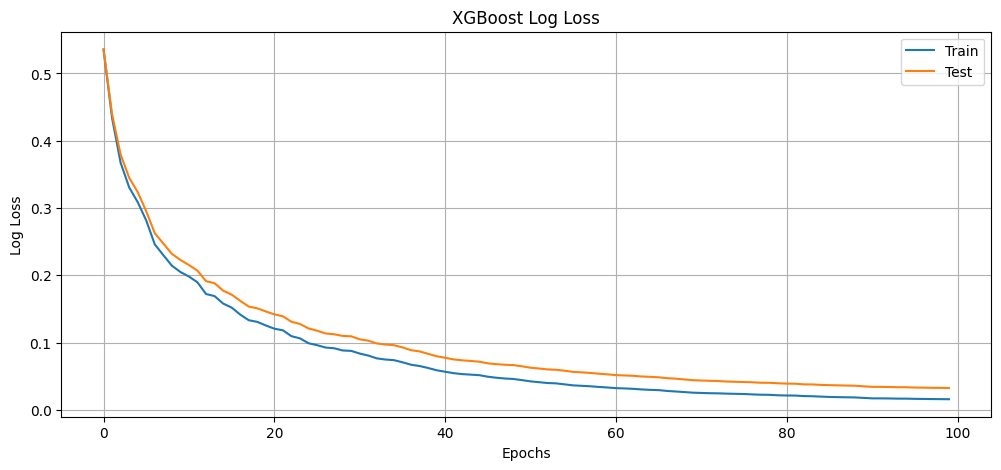

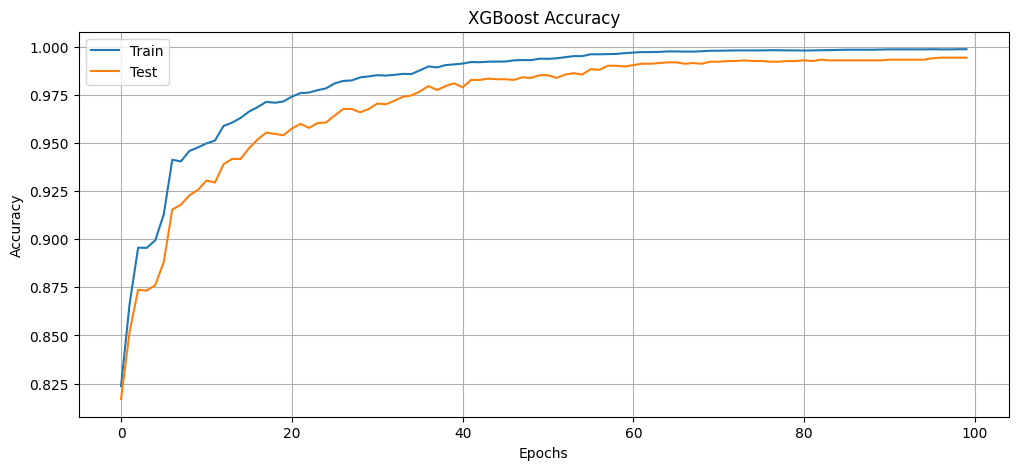

In [17]:
# Plotting loss 
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
ax.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# Plotting accuracy 
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(x_axis, [1 - x for x in results['validation_0']['error']], label='Train')
ax.plot(x_axis, [1 - x for x in results['validation_1']['error']], label='Test')
ax.legend()
ax.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('XGBoost Accuracy')
plt.show()

In [20]:
def plot_true_predicted(y_true, y_predict, n_points, model):
    #Visualize true vs predicted labels ( first 100 seconds of test data)
    plt.figure(figsize=(12,6))
    plt.plot(y_true[:n_points], label='True Labels', marker ='o', linestyle='-', color = 'blue')
    plt.plot(y_predict[:n_points], label='Predicted Labels', marker ='x', linestyle='-', color = 'orange')
    plt.xlabel('Time(seconds)')
    plt.ylabel('Performance label')
    plt.title(f'{model}: True vs Predicted labels (first {n_points} seconds)')
    plt.legend()
    plt.grid(True)
    plt.show()

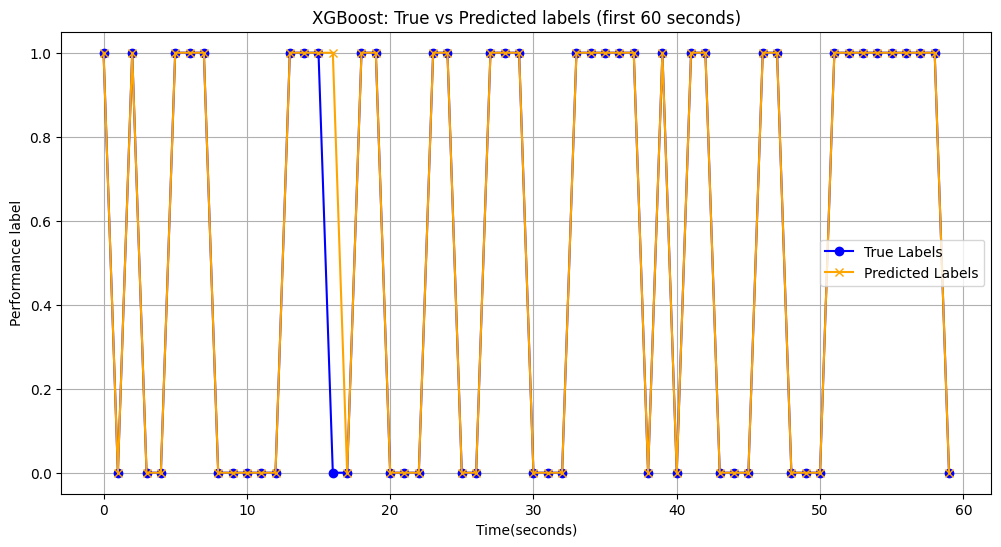

Accuracy: 99.44%


In [21]:
predictions = model_1.predict(X_test)
y_pred = (predictions > 0.5).astype(int)
plot_true_predicted(y_test, y_pred, 60, 'XGBoost')

# Print accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Model 2 : CNN

In [8]:
# Create sliding windows
def create_windows(X, y, window_size=60, stride=30):
    windows = []
    labels = []
    for i in range(X.shape[0]):  # For each student
        for j in range(0, X.shape[1] - window_size + 1, stride):
            windows.append(X[i, j:j+window_size, :])
            labels.append(y[i, j+window_size-1])  # Label of the last timestep in the window
    return np.array(windows), np.array(labels)

# Data loading

In [9]:
# Reshape training data for CNN inputs (samples, timesteps, features)
X_2 = X.reshape(10, -1, 5)  # 10 students, ~1200 time steps, 5 features
y_2 = y.reshape(10, -1)

# Create sliding windows
X_windowed, y_windowed = create_windows(X_2, y_2)
    
# Split data into train and test sets
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_windowed, y_windowed, test_size=0.2, random_state= 7)# Normalize the data
scaler = StandardScaler()
X_train_2 = scaler.fit_transform(X_train_2.reshape(-1, X_train_2.shape[-1])).reshape(X_train_2.shape)
X_test_2 = scaler.transform(X_test_2.reshape(-1, X_test_2.shape[-1])).reshape(X_test_2.shape)


# Building 1D CNN model

In [10]:
# Build the 1D CNN model
def build_model(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [18]:
# Function for plotting loss and accuracy 
import matplotlib.pyplot as plt


def plot_loss_vs_epoch(history):
    plt.figure(figsize=(12, 5))
    
    # Plot training loss
    plt.plot(history.history['loss'], label='Train', color='blue')
    
    # Plot validation loss (which represents the testing dataset)
    plt.plot(history.history['val_loss'], label='Test', color='orange')
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('CNN Loss')
    plt.legend()
    plt.grid(True)
    plt.show()



def plot_accuracy_vs_epoch(history):
    plt.figure(figsize=(12, 5))
    
    # Plot training loss
    plt.plot(history.history['accuracy'], label='Train', color='blue')
    
    # Plot validation loss (which represents the testing dataset)
    plt.plot(history.history['val_accuracy'], label='Test', color='orange')
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('CNN Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Model initlialization, fitting and evaluation

Epoch 1/100
147/147 [==============================] - 1s 3ms/step - loss: 0.6715 - accuracy: 0.5952 - val_loss: 0.6835 - val_accuracy: 0.5270
Epoch 2/100
147/147 [==============================] - 0s 1ms/step - loss: 0.5820 - accuracy: 0.6361 - val_loss: 0.6053 - val_accuracy: 0.7027
Epoch 3/100
147/147 [==============================] - 0s 1ms/step - loss: 0.5329 - accuracy: 0.6803 - val_loss: 0.6273 - val_accuracy: 0.7027
Epoch 4/100
147/147 [==============================] - 0s 1ms/step - loss: 0.4888 - accuracy: 0.7211 - val_loss: 0.5977 - val_accuracy: 0.6622
Epoch 5/100
147/147 [==============================] - 0s 1ms/step - loss: 0.4640 - accuracy: 0.7245 - val_loss: 0.6157 - val_accuracy: 0.7162
Epoch 6/100
147/147 [==============================] - 0s 1ms/step - loss: 0.4199 - accuracy: 0.7993 - val_loss: 0.6566 - val_accuracy: 0.6486
Epoch 7/100
147/147 [==============================] - 0s 1ms/step - loss: 0.4401 - accuracy: 0.8027 - val_loss: 0.6458 - val_accuracy: 0.6757

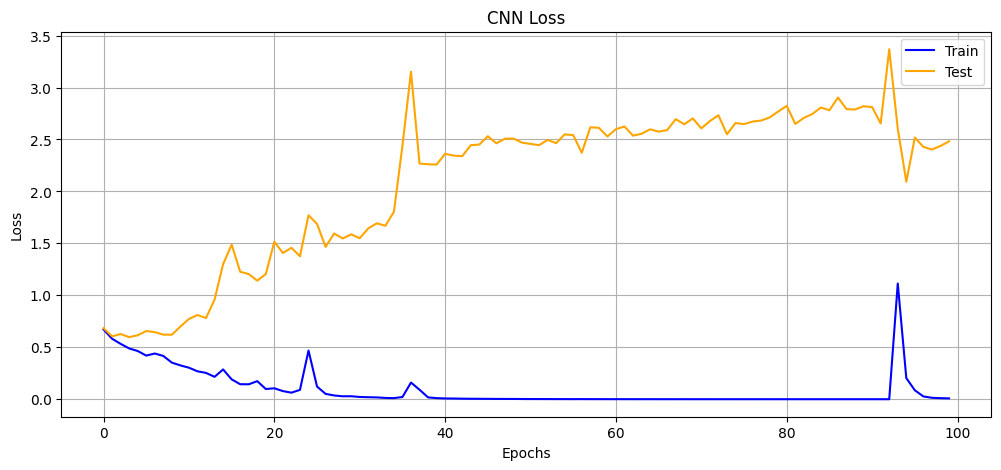

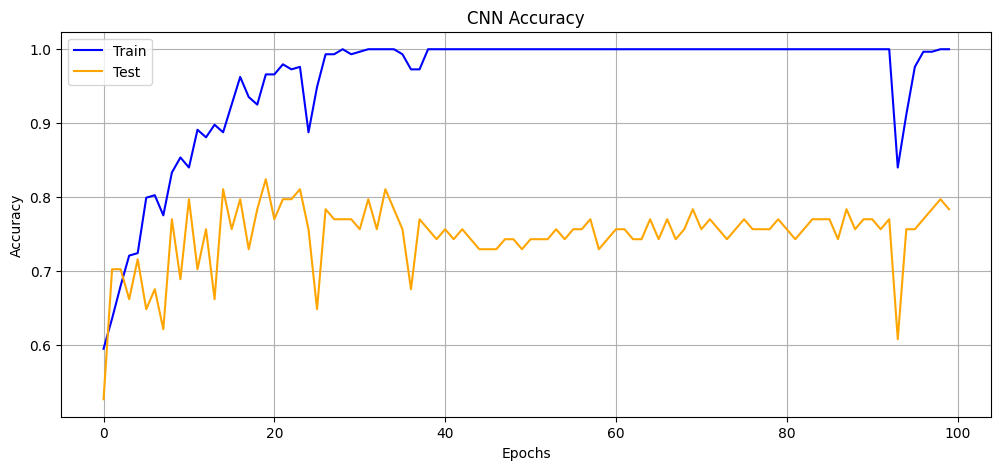

3/3 [==============================] - 0s 2ms/step - loss: 3.3083 - accuracy: 0.7500
Test accuracy: 0.7500
3/3 [==============================] - 0s 1ms/step


In [19]:
# Build and train the model
model_2 = build_model(input_shape=(X_train_2.shape[1], X_train_2.shape[2]))
# model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32)

history = model_2.fit(X_train_2, y_train_2, validation_split=0.2, epochs=100, batch_size=2)

# Generate the plot
plot_loss_vs_epoch(history)
plot_accuracy_vs_epoch(history)

# Evaluate the model
loss, accuracy = model_2.evaluate(X_test_2, y_test_2)
print(f"Test accuracy: {accuracy:.4f}")
    
# Make predictions
predictions_2 = model_2.predict(X_test_2)
    

3/3 [==============================] - 0s 2ms/step


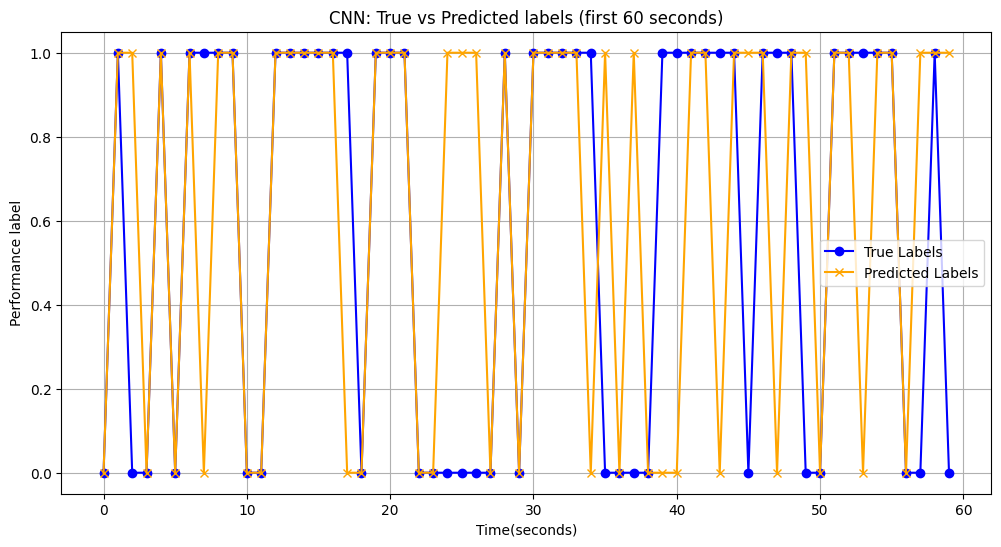

Accuracy: 75.00%


In [23]:
predictions_2 = model_2.predict(X_test_2)
y_pred_2 = (predictions_2 > 0.5).astype(int)
plot_true_predicted(y_test_2, y_pred_2, 60, 'CNN')

# Print accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test_2, y_pred_2)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Explainability using SHAP

In [25]:
import xgboost
import shap
Xd = xgboost.DMatrix(X, label=y)
explainer = shap.TreeExplainer(model_1)
explanation = explainer(Xd)
shap_values = explanation.values

In [26]:
shap_interaction_values = explainer.shap_interaction_values(Xd)
shap_interaction_values[0]

array([[ 0.11930712,  0.94097066,  0.2950307 ,  0.7769244 , -0.17773862],
       [ 0.9409715 ,  5.836377  ,  0.6139971 , -1.7846388 , -0.02882409],
       [ 0.29503113,  0.61399627, -0.9908882 , -0.04377225, -0.01516919],
       [ 0.7769245 , -1.7846395 , -0.04377215,  1.7809399 ,  0.029688  ],
       [-0.17773885, -0.02882481, -0.01516921,  0.02968788, -0.2894101 ]],
      dtype=float32)

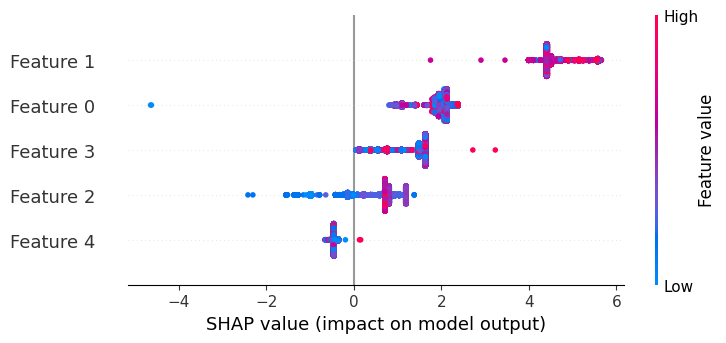

In [27]:
shap.plots.beeswarm(explanation)

In [51]:
X[5]

array([   4.04387691,   40.00120778,    0.        , 3028.0744    ,
       3028.078284  ])

In [55]:
y[1430]

1

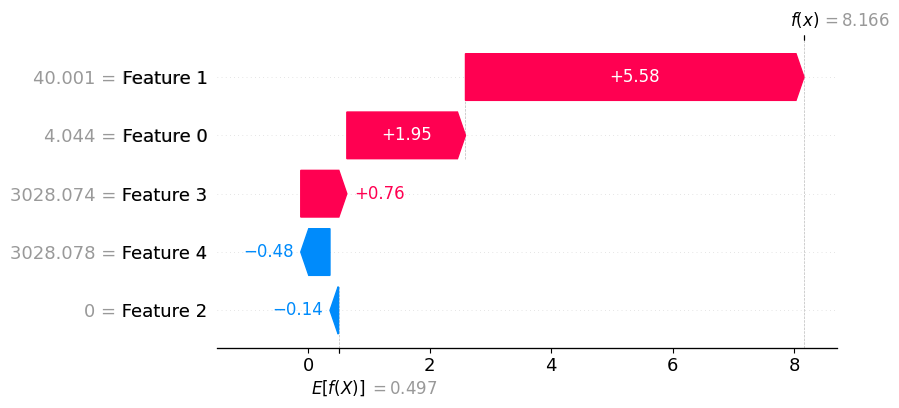

In [48]:
# Plot the SHAP waterfall plot
shap.plots.waterfall(explanation[5])

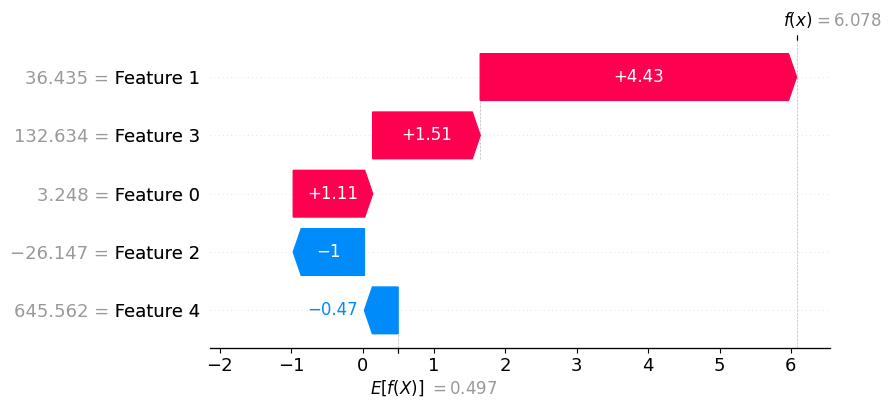

In [64]:
shap.plots.waterfall(explanation[990])

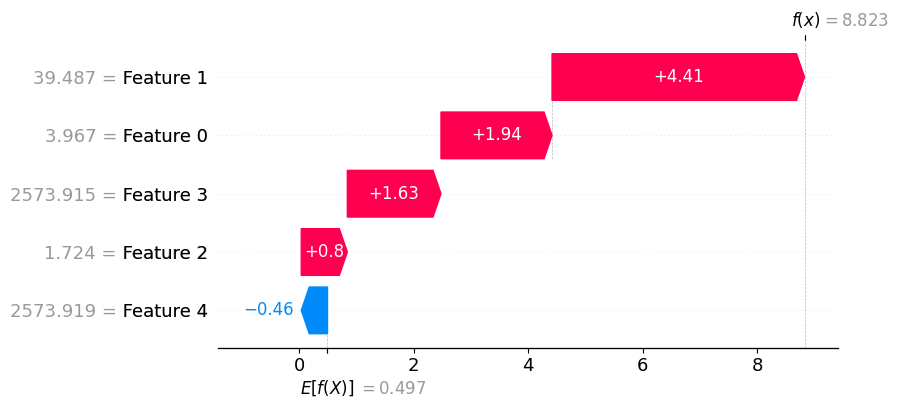

In [50]:
shap.plots.waterfall(explanation[99])

In [53]:
y[99]

0